Project3-keras_OCR
===
---

목표: OCR파이프라인가 아닌 keras ocr의 detector를 통해 이미지에서 글자를 찾아내고 읽어내는 모델과 함수를 만들어보자.


#### 데이터 경로 설정

In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/home/aiffel-dj63/aiffel/ocr


[논문 : An End-to-End Trainable Neural Network for Image-based SequenceRecognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf)

![image](https://user-images.githubusercontent.com/70703320/115818094-fc1ed380-a436-11eb-9a0f-6a7467bd1a53.png)


#### 몇 개의 셀이 필요한지 찾아보기

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


#### 필요한 라이브러리들을 import

In [3]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

# 로컬 사용자
TRAIN_DATA_PATH = HOME_DIR+'/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/MJ/MJ_test'

# 클라우드 사용자는 아래 주석을 사용해 주세요.
# TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
# VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
# TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'
print(TRAIN_DATA_PATH)

/home/aiffel-dj63/aiffel/ocr/MJ/MJ_train


#### 데이터셋 안에 들어있는 이미지가 실제로 어떻게 생겼는지 확인

lmdb를 통해 훈련데이터셋의 이미지를 4개만 열어서 실제 shape가 어떻게 생겼는지, 이미지나 라벨은 어떻게 달려 있는지를 확인

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


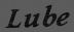

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


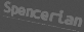

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


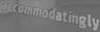

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


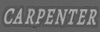

In [4]:
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

#### lmdb를 활용하여 케라스 모델 학습용 MJ Synth 데이터셋 클래스를 구현

- `dataset_path` :: 읽어들일 데이터셋의 경로
- `label_converter` :: 문자를 미리정의된 index로 변환해주는 converter로 직접 구현

batch_size와 입력이미지 크기 그리고 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character등을 입력으로 받도록 구현

In [5]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path,
                      label_converter,
                      batch_size=1,
                      img_size=(100,32),
                      max_text_len=22,
                      is_train=False,
                      character=''
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            num_samples = int(txn.get('num-samples'.encode()))
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 가져오는 메소드
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width,self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    # idx번째 배치를 가져오는 메소드
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

- 이미지 데이터를 img, label의 쌍으로 가져오는 부분은 `_get_img_label()` 메소드에 반영
- `model.fit()`에서 호출되는 `__getitem__()` 메소드에서 배치 단위만큼 `_get_img_label()` 를 통해 가져온 데이터셋을 리턴
- `_get_img_label()` 를 보면 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지로 맞추게끔 가공


- `__init__()` 에서는 입력으로 받은 text를 `self.dict`에 각 character들이 어떤 index에 매핑되는지 저장합니다. 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어집니다. 만약 `character='ABCD'`라면 `'A'`의 label은 1, `'B'`의 label은 2가 됩니다.
- 공백(blank) 문자를 지정합니다. 여기서는 공백 문자를 뜻하기 위해 `'-'`를 활용하며, label은 0으로 지정합니다.
- `decode()`는 각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 바꾸어줍니다.


같은 글자가 연속으로 이어지는 경우에는 이어지는 그 사이에 공백 문자의 label을 포함해야함

#### 글자로 바꿔주는 class 만들어주기 (인코디와 디코더 포함)

In [6]:
class LabelConverter(object):
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

#### 인코딩과 디코딩 확인

In [7]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


#### `ctc_lambda_func`함수 :: `K.ctc_batch_cost()`를 활용해서 loss를 계산

In [8]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

LabelConverter.encode() 메소드에 공백문자 처리로직을 포함했던 것 => 중복되는 문자와 중복되지 않는 문자를 구분해주기 위함

- `y_true`: tensor (samples, max_string_length) containing the truth labels.
- `y_pred`: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
- `input_length tensor`: (samples, 1) containing the sequence length for each batch item in y_pred.
- `label_length tensor`: (samples, 1) containing the sequence length for each batch item in y_true.

<Br/>
<Br/>

- y_true: 실제 라벨 LUBE. 그러나 텍스트 라벨 그대로가 아니라, 각 글자를 One-hot 인코딩한 형태로서, max_string_length 값은 모델에서 22로 지정할 예정
- y_pred: 우리가 만들 RCNN 모델의 출력 결과. 그러나 길이는 4가 아니라 우리가 만들 RNN의 최종 출력 길이로서 24가 될 예정
- input_length tensor: 모델 입력 길이 T로서, 이 경우에는 텍스트의 width인 74
- label_length tensor: 라벨의 실제 정답 길이 U로서, 이 경우에는 4

In [9]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')

    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

#### MJDatasetSequence로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습

In [10]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

model, y_func = build_crnn_model()
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
        steps_per_epoch=len(val_set),
        epochs=100,
        validation_data=val_set,
        validation_steps=len(val_set),
        callbacks=[ckp])

Epoch 1/100
63/63 [==============================] - 26s 165ms/step - loss: 33.5206 - val_loss: 27.1466

Epoch 00001: val_loss improved from inf to 27.14655, saving model to /home/aiffel-dj63/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/100
63/63 [==============================] - 9s 149ms/step - loss: 26.5765 - val_loss: 26.6852

Epoch 00002: val_loss improved from 27.14655 to 26.68524, saving model to /home/aiffel-dj63/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/100
63/63 [==============================] - 9s 146ms/step - loss: 26.3020 - val_loss: 25.9146

Epoch 00003: val_loss improved from 26.68524 to 25.91463, saving model to /home/aiffel-dj63/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/100
63/63 [==============================] - 8s 132ms/step - loss: 25.8609 - val_loss: 27.6471

Epoch 00004: val_loss did not improve from 25.91463
Epoch 5/100
63/63 [==============================] - 9s 138ms/step - loss: 25.7410 - val_loss: 25.6810

Epoch 00005: val_loss improved from 25.91463 to 25.68101,

Epoch 39/100
63/63 [==============================] - 9s 142ms/step - loss: 5.0445 - val_loss: 5.1829

Epoch 00039: val_loss improved from 5.47524 to 5.18294, saving model to /home/aiffel-dj63/aiffel/ocr/model_checkpoint.hdf5
Epoch 40/100
63/63 [==============================] - 8s 134ms/step - loss: 5.0557 - val_loss: 5.1543

Epoch 00040: val_loss improved from 5.18294 to 5.15428, saving model to /home/aiffel-dj63/aiffel/ocr/model_checkpoint.hdf5
Epoch 41/100
63/63 [==============================] - 8s 134ms/step - loss: 5.0360 - val_loss: 5.0445

Epoch 00041: val_loss improved from 5.15428 to 5.04447, saving model to /home/aiffel-dj63/aiffel/ocr/model_checkpoint.hdf5
Epoch 42/100
63/63 [==============================] - 9s 138ms/step - loss: 4.6221 - val_loss: 4.8906

Epoch 00042: val_loss improved from 5.04447 to 4.89062, saving model to /home/aiffel-dj63/aiffel/ocr/model_checkpoint.hdf5
Epoch 43/100
63/63 [==============================] - 8s 132ms/step - loss: 4.5767 - val_loss: 4

Epoch 83/100
63/63 [==============================] - 9s 136ms/step - loss: 3.0352 - val_loss: 3.3655

Epoch 00083: val_loss improved from 3.37526 to 3.36553, saving model to /home/aiffel-dj63/aiffel/ocr/model_checkpoint.hdf5
Epoch 84/100
63/63 [==============================] - 9s 138ms/step - loss: 3.2284 - val_loss: 3.4266

Epoch 00084: val_loss did not improve from 3.36553
Epoch 85/100
63/63 [==============================] - 9s 146ms/step - loss: 3.1712 - val_loss: 3.2570

Epoch 00085: val_loss improved from 3.36553 to 3.25703, saving model to /home/aiffel-dj63/aiffel/ocr/model_checkpoint.hdf5
Epoch 86/100
63/63 [==============================] - 9s 135ms/step - loss: 3.1340 - val_loss: 3.3148

Epoch 00086: val_loss did not improve from 3.25703
Epoch 87/100
63/63 [==============================] - 9s 135ms/step - loss: 3.0688 - val_loss: 3.2874

Epoch 00087: val_loss did not improve from 3.25703
Epoch 88/100
63/63 [==============================] - 9s 138ms/step - loss: 3.1195 - v

#### 학습한 모델을 테스트셋에서 inference해보고 이를 눈으로 직접 확인

Result: 	 SLINKING9999999999999999


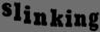

Result: 	 ALEPPO99999999999999999


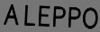

Result: 	 IRWANDA99999999999999999


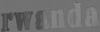

Result: 	 NATHANS99999999999999999


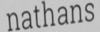

Result: 	 HALEO9999999999999999999


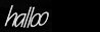

Result: 	 HURLS9999999999999999999


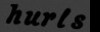

Result: 	 DOWNSIZE9999999999999999


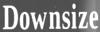

Result: 	 ROBOTIC99999999999999999


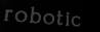

Result: 	 SLOPPY99999999999999999


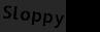

Result: 	 HERMITE99999999999999999


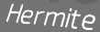

In [11]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()

model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)

#### 이미지에서 글자를 찾아내는 함수

Looking for /home/aiffel-dj63/.keras-ocr/craft_mlt_25k.h5
img 
 [[[201 206 205]
  [197 202 201]
  [190 195 194]
  ...
  [182 186 191]
  [177 181 186]
  [176 180 185]]

 [[175 180 179]
  [174 179 178]
  [173 178 177]
  ...
  [178 182 187]
  [180 184 189]
  [181 185 190]]

 [[176 181 180]
  [177 182 181]
  [178 183 182]
  ...
  [183 187 192]
  [189 193 198]
  [190 194 199]]

 ...

 [[103  78  58]
  [106  81  61]
  [107  82  62]
  ...
  [102  71  56]
  [103  72  57]
  [103  72  57]]

 [[103  78  58]
  [106  81  61]
  [107  82  62]
  ...
  [104  74  57]
  [104  74  57]
  [105  75  58]]

 [[103  78  58]
  [106  81  61]
  [107  82  62]
  ...
  [105  75  58]
  [106  76  59]
  [106  76  59]]] 
 -------------------------------------------------
input_img 
 [[[[201 206 205]
   [197 202 201]
   [190 195 194]
   ...
   [182 186 191]
   [177 181 186]
   [176 180 185]]

  [[175 180 179]
   [174 179 178]
   [173 178 177]
   ...
   [178 182 187]
   [180 184 189]
   [181 185 190]]

  [[176 181 180]
   

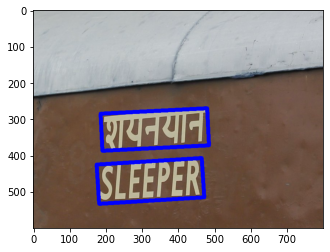

In [12]:
from keras_ocr.detection import Detector
from matplotlib import pyplot as plt 
import tensorflow as tf
import os
import keras_ocr
import cv2



HOME_DIR = os.getenv('HOME')+'/aiffel/ocr/'
SAMPLE_IMG_PATH = HOME_DIR + 'sample.jpg'

def detect_text(img_path):
    
    # Detector를 객체로 만들기
    detector = Detector()
    # 이미지 경로에서 픽셀의 값을 읽어옴
    img = cv2.imread(img_path)
    print('img','\n',img,'\n', '-------------------------------------------------')
    # 2중 리스트를 3중 리스트로 만들어줌
    input_img = img[tf.newaxis, ... ]
    print('input_img','\n',input_img,'\n', '-------------------------------------------------')
    # 이미지에서 글자부분을 찾아 바운딩 박스의 꼭지점 부분의 x좌표와 y좌표를 얻어옴
    result = detector.detect(input_img)
    print('result','\n',result,'\n', '-------------------------------------------------')
    # 3중 리스트에서 2중 리스트로 만들어줌
    ocr_result = result[0]
    print('ocr_result','\n',ocr_result,'\n', '-------------------------------------------------')
    
    # 빈리스트 만들기
    cropped_imgs = []
    # 여러 개의 바운딩 박스에서 하나씩 가져옴
    for text_result in ocr_result:
        # 4 꼭지점에서 2개씩 선으로 이어줌
        for i in range(4):
            if i == 3:
                img = cv2.line(img, tuple(text_result[3]), tuple(text_result[0]), (0,0,255), 10)
            else:
                img = cv2.line(img, tuple(text_result[i]), tuple(text_result[i+1]), (0,0,255), 10)
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        cropped_imgs.append(img[int(y_min):int(y_max), int(x_min):int(x_max)])
        
    return img, cropped_imgs

img, cropped_img = detect_text(SAMPLE_IMG_PATH)
plt.imshow(img)

#### 이미지에서 문자를 인식해내는 함수 만들기 :: 실패

In [ ]:
def recognize_img(img, input_img_size=(100,32)):
   
    check_inference(model, test_set, index=10)
    
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!

#### 잘라낸 이미지에서 글자를 인식한 것 확인

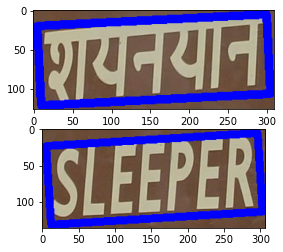

In [13]:
for i, _img in enumerate(cropped_img):
    plt.subplot(2,1,i+1)
    plt.imshow(_img)

## 회고

- detect_text
    - Keras_ocr에서 Detector와 Recognizer를 이용해야 하는 노드였다. pillow를 사용해야 했는데 잘 활용하지 않고 opencv를 많이 활용한다고 들었다. 이미지를 다루는게 익숙하지 않고 잘 모르는 부분이 많았다. 마침 게더에서 잘하시는 한 분이 해결하시고 계셨다. 그분이 해결하시는 과정을 공유해주셔서 참고하였다. 대신에 다시 코드 한줄한줄의 의미를 잘 찾아보았다. opencv를 잘 공부해두어야겠다.

- recognize_img
    - 이미지에서 단어를 인식하는 함수는 만들기가 도저히 어려웠다. recogizer=Recognizer()를 사용했으나 계속오류가 나서 reconize(img_cropped)를 확인할 수 없었다.
    

## 루브릭
1. Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다.

텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다.


2. CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다.

학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.


3. keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다.

샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.